In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pycbc import psd as pypsd
from pycbc.inference.models import GaussianNoise
from pycbc.waveform.generator import (FDomainDetFrameGenerator,FDomainCBCGenerator)
from pycbc.psd import EinsteinTelescopeP1600143


In [3]:
seglen = 4
sample_rate = 2048

N = int(seglen * sample_rate / 2 + 1) # Number of samples in the frequency series

fmin = 5.

# Paramètres d'un signal de CBC (16 en tout)
cbc_params = {
              # Paramètres intrinsèques à la source
              'mass1': 38.6,
              'mass2': 29.3,
              'spin1x': 0., 'spin2x': 0.,  'spin1y': 0., 'spin2y': 0.,  'spin1z': 0., 'spin2z': 0.,
              'eccentricity': 0,
              # Paramètres extrinsèques
              'ra': 1.37, 'dec': -1.26, 'distance': 1000,
              'polarization': 2.76, 'inclination': 0,
              'tc': 3.1 , 'coa_phase': 0}

cbc_params['approximant'] = 'IMRPhenomD'
cbc_params['f_lower'] =  fmin

In [4]:
# Définition du générateur
generator = FDomainDetFrameGenerator(
    FDomainCBCGenerator, 0., detectors=['H1', 'L1'],
    delta_f=1./seglen, **cbc_params)

# Génération du signal
signal = generator.generate()
print(signal)

{'H1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbd0cbbbc10>, 'L1': <pycbc.types.frequencyseries.FrequencySeries object at 0x7fbbe18c6cd0>}


/home/victor-glorieux/.conda/envs/cop_adrian/lib/python3.9/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other


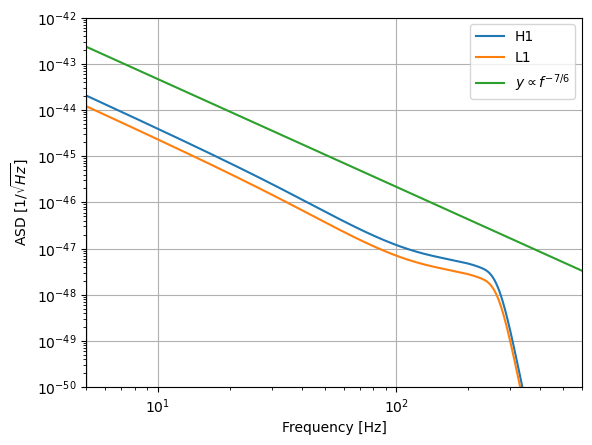

In [5]:
plt.loglog(signal['H1'].get_sample_frequencies(), np.abs(signal['H1'])**2,label='H1')
plt.loglog(signal['L1'].get_sample_frequencies(), np.abs(signal['L1'])**2, label='L1')

plt.xlabel('Frequency [Hz]')
plt.ylabel(r'ASD [1/$\sqrt{Hz}]$')
y = signal['H1'].get_sample_frequencies()**(-7/3)
plt.loglog(signal['H1'].get_sample_frequencies(), 1e-41*y, label=r'$y\propto f^{-7/6}$')
plt.legend()
plt.ylim(1e-50, 1e-42)
plt.xlim(5, 600)
plt.grid()

In [6]:
psd = EinsteinTelescopeP1600143(N, 1./seglen, fmin)
psds = {'H1': psd, 'L1': psd}
low_frequency_cutoff = {'H1': fmin, 'L1': fmin}

model = GaussianNoise(['mass1', 'mass2', 'tc'], signal, low_frequency_cutoff,
                          psds=psds, static_params=cbc_params)

In [7]:
model.update()
print('Log likelihood: {:.2f}'.format(model.loglikelihood))
print('Log likelihood noise: {:.2f}'.format(model.lognl))
print('Log likelihood ratio: {:.2f}'.format(model.loglr))

Log likelihood: 0.00
Log likelihood noise: -179203.23
Log likelihood ratio: 179203.23


In [8]:
snr_H1_sq = model.det_optimal_snrsq('H1')
snr_L1_sq = model.det_optimal_snrsq('L1')

log_noise_likelihood_from_SNR = -0.5 * (snr_H1_sq + snr_L1_sq)

print('SNR H1: {:.2f}'.format(snr_H1_sq**0.5))
print('SNR L1: {:.2f}'.format(snr_L1_sq**0.5))

print('Expected log likelihood noise: {:.2f}'.format(log_noise_likelihood_from_SNR))

SNR H1: 474.95
SNR L1: 364.46
Expected log likelihood noise: -179203.23


### Variation d'un paramètre

On fait varier $t_c$ ici et on vérifie que la max du likelihood soit atteint pour sa bonne valeur.

In [10]:
tsig = 3.1
tc_test = np.arange(tsig-1, tsig+1, 0.1)
ll_ratio_test = np.zeros_like(tc_test)

for i, t in enumerate(tc_test):
    model.update(tc=t)
    ll_ratio_test[i] = model.loglr

Text(0, 0.5, 'Log($\\mathcal{L}$) ratio')

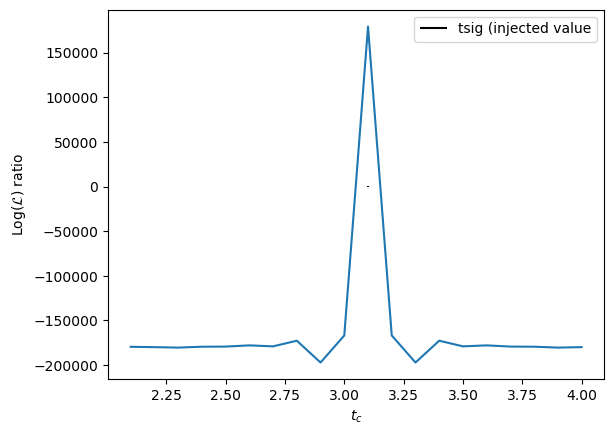

In [14]:
plt.plot(tc_test, ll_ratio_test)
plt.vlines(tsig, -300, 300, color='black', label="tsig (injected value")
plt.legend()
plt.xlabel(r"$t_c$")
plt.ylabel(r"Log($\mathcal{L}$) ratio")

In [ ]:
from scipy.optimize import minimize
import matplotlib.animation as animation

ll_ratio_test = []
tc_list = []
mass1_list = []

def likelihood_calculation(params):
    tc_list.append(params[0])
    mass1_list.append(params[1])
    model.update(tc=params[0],mass1=params[1])
    mloglik = - model.loglr
    ll_ratio_test.append(mloglik)
    return mloglik

#true params : (tc=3.1, mass1=38.6, mass2=29.3, distance = 1000)
initial_params = [3, 38, 29, 950]
#Nelder-Mead
result = minimize(likelihood_calculation, method = 'Nelder-Mead', x0=initial_params, tol=1e-12)
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 116407.5852859072
             x: [ 3.155e+00  3.556e+01]
           nit: 112
          nfev: 260
 final_simplex: (array([[ 3.155e+00,  3.556e+01],
                       [ 3.155e+00,  3.556e+01],
                       [ 3.155e+00,  3.556e+01]]), array([ 1.164e+05,  1.164e+05,  1.164e+05]))


### Minimisation en utilisant un DataFrame : minimum locaux

Facilité la récupération des données

In [128]:
import pandas as pd

params_dataFrame = pd.DataFrame(data={'mloglik': [],'tc': [], 'mass1': [],
                                     'mass2': [], 'distance': [], 'ra' : [], 'dec' : []})
k=0

def likelihood_calculation(params):

    global params_dataFrame, k
    model.update(tc=params[0],mass1=params[1],mass2=params[2],distance=params[3],ra=params[4],dec=params[5])
    mloglik = - model.loglr

    add = pd.DataFrame(data={'mloglik': mloglik, 'tc': params[0], 'mass1': params[1],
                             'mass2': params[2], 'distance': params[3], 'ra' : params[4],
                             'dec' : params[5]},index=[k])
    params_dataFrame = pd.concat([params_dataFrame,add])
    k +=1

    return mloglik

#true params : (tc=3.1, mass1=38.6, mass2=29.3, distance = 1000, ra = 1.37, dec = -1.26)
initial_params = [2, 30, 25, 950, 1, -1]
#Nelder-Mead
result = minimize(likelihood_calculation, method = 'Nelder-Mead', x0=initial_params, tol=1e-12)

/tmp/ipykernel_2063143/680909320.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axhline(float(data_tail['mass1']),linestyle = 'dashed',color='r')
/tmp/ipykernel_2063143/680909320.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.axvline(float(data_tail['tc']),linestyle = 'dashed',color='r')


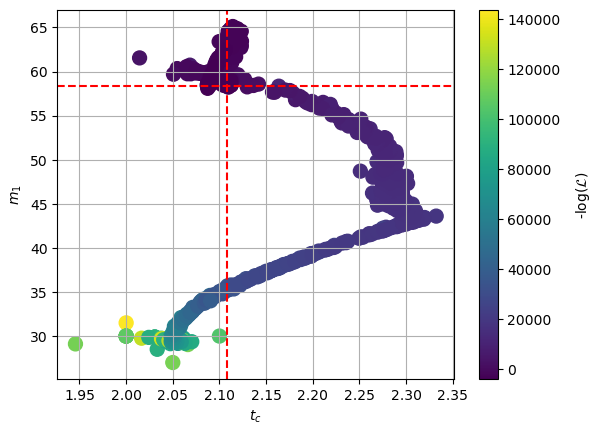

In [130]:
tc_list=params_dataFrame['tc']
mass1_list=params_dataFrame['mass1']
mass2_list=params_dataFrame['mass2']
distance_list=params_dataFrame['distance']
ra_list=params_dataFrame['ra']
dec_list=params_dataFrame['dec']
ll_ratio_test=params_dataFrame['mloglik']

plt.scatter(tc_list, mass1_list, c=ll_ratio_test, cmap='viridis', s=100)
plt.xlabel(r'$t_c$')
plt.ylabel(r'$m_1$')
plt.grid()
data_tail = params_dataFrame.tail(1)
plt.axhline(float(data_tail['mass1']),linestyle = 'dashed',color='r')
plt.axvline(float(data_tail['tc']),linestyle = 'dashed',color='r')
colorbar = plt.colorbar(orientation='vertical')
colorbar.set_label(r'-log($\mathcal{L}$)', labelpad=10)

### Plot de tous les procédés de minimisation (minimums locaux)

/tmp/ipykernel_2063143/2824502727.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axhline(float(data_tail[data_y]),linestyle = 'dashed',color='r')
/tmp/ipykernel_2063143/2824502727.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.axvline(float(data_tail[data_x]),linestyle = 'dashed',color='r')


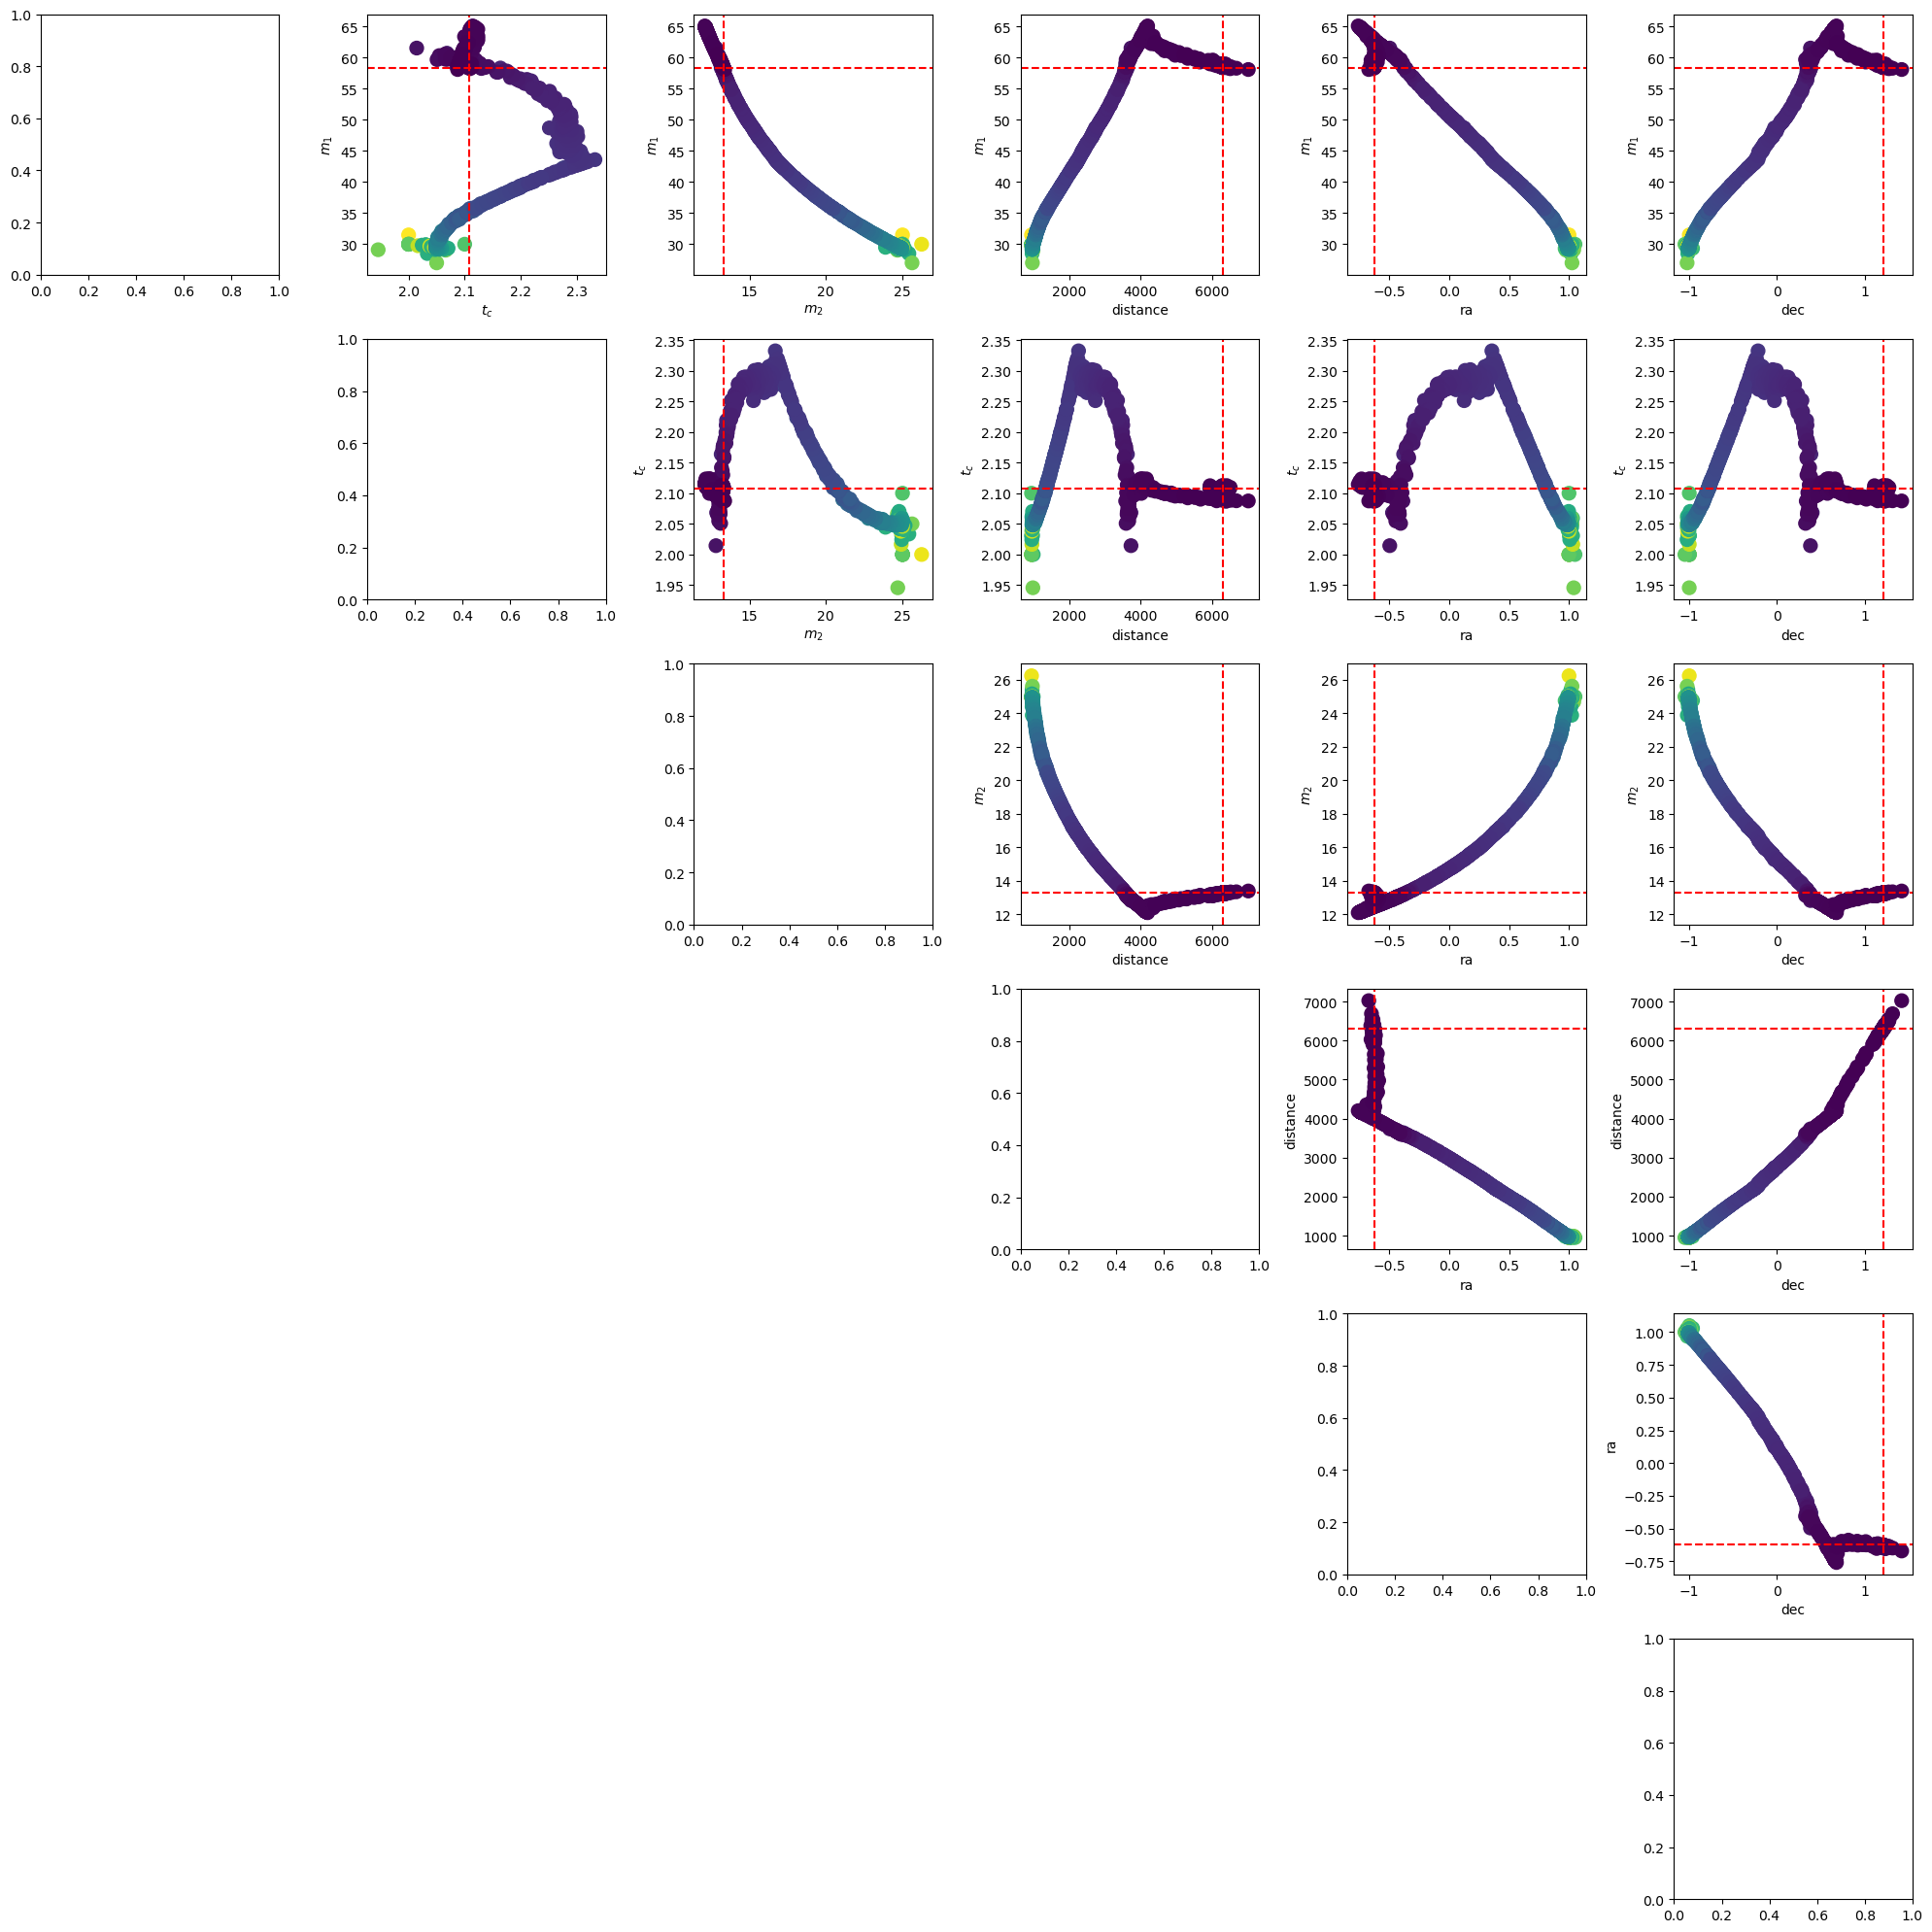

In [ ]:
fig, axs = plt.subplots(nrows=6,ncols=6,figsize=(20,20))

def plot_corr(x_list,y_list,label_x,label_y,data_x,data_y,ax):
    ax.scatter(x_list, y_list, c=ll_ratio_test, cmap='viridis', s=100)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    ax.axhline(float(data_tail[data_y]),linestyle = 'dashed',color='r')
    ax.axvline(float(data_tail[data_x]),linestyle = 'dashed',color='r')

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],  axs[1,2],    axs[1,3],      axs[1,4], axs[1,5], axs[2,3],      axs[2,4],   axs[2,5],   axs[3,4],      axs[3,5],      axs[4,5]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   mass2_list, distance_list, ra_list,  dec_list, distance_list, ra_list,    dec_list,   ra_list,       dec_list,      dec_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,  mass2_list,    mass2_list, mass2_list, distance_list, distance_list, ra_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'$m_2$',   r'distance',   r'ra',    r'dec',   r'distance',   r'ra',      r'dec',     r'ra',         r'dec',        r'dec']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$', r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'ra']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'mass2',    'distance',    'ra',     'dec',    'distance',    'ra',       'dec',      'ra',          'dec',         'dec']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',     'mass2',       'mass2',     'mass2',    'distance',    'distance',    'ra']

for i in range(len(axs_list)):
    plot_corr(x_list[i],y_list[i],label_x[i],label_y[i],data_x[i],data_y[i],axs_list[i])

fig.tight_layout()

axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4]]
for i in axs_off:
    i.axis('off')


### Minimisation en utilisant un DataFrame : minimums globaux

On utilise cette fois la fonction scipy.optimize.basinhopping

In [137]:
from scipy.optimize import basinhopping

params_dataFrame_glob = pd.DataFrame(data={'mloglik': [],'tc': [], 'mass1': [],
                                     'mass2': [], 'distance': [], 'ra' : [], 'dec' : []})
k=0

def likelihood_calculation_glob(params):

    global params_dataFrame_glob, k
    model.update(tc=params[0],mass1=params[1],mass2=params[2],distance=params[3],ra=params[4],dec=params[5])
    mloglik = - model.loglr

    add = pd.DataFrame(data={'mloglik': mloglik, 'tc': params[0], 'mass1': params[1],
                             'mass2': params[2], 'distance': params[3], 'ra' : params[4],
                             'dec' : params[5]},index=[k])
    params_dataFrame_glob = pd.concat([params_dataFrame_glob,add])
    k +=1

    return mloglik

#true params : (tc=3.1, mass1=38.6, mass2=29.3, distance = 1000, ra = 1.37, dec = -1.26)
initial_params = [2, 30, 25, 950, 1, -1]
#Nelder-Mead
minimizer_kwargs = dict(method="L-BFGS-B") #, bounds=bounds
result_glob = basinhopping(likelihood_calculation_glob, x0=initial_params, minimizer_kwargs=minimizer_kwargs)

XLAL Error - XLALSimIMRPhenomDGenerateFD (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1692629236402/work/lib/LALSimIMRPhenomD.c:151): (fCut = 4.19853 Hz) <= f_min = 5

XLAL Error - XLALSimIMRPhenomDGenerateFD (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1692629236402/work/lib/LALSimIMRPhenomD.c:151): Input domain error
XLAL Error - XLALSimInspiralChooseFDWaveform_legacy (/home/conda/feedstock_root/build_artifacts/lalsimulation-split_1692629236402/work/lib/LALSimInspiralGeneratorLegacy.c:1592): Internal function call failed: Input domain error


FailedWaveformError: Failed to generate waveform with parameters:
delta_f: 0.25 | delta_t: 0.00048828125 | mass1: 4370.632841895911 | mass2: 5300.627359624694 | spin1x: 0.0 | spin2x: 0.0 | spin1y: 0.0 | spin2y: 0.0 | spin1z: 0.0 | spin2z: 0.0 | eccentricity: 0 | distance: 981.998247857986 | inclination: 0 | coa_phase: 0 | approximant: IMRPhenomD | f_lower: 5.0
Error was: Internal function call failed: Input domain error

In [ ]:
tc_list=params_dataFrame_glob['tc']
mass1_list=params_dataFrame_glob['mass1']
mass2_list=params_dataFrame_glob['mass2']
distance_list=params_dataFrame_glob['distance']
ra_list=params_dataFrame_glob['ra']
dec_list=params_dataFrame_glob['dec']
ll_ratio_test=params_dataFrame_glob['mloglik']

fig_2, axs = plt.subplots(nrows=6,ncols=6,figsize=(20,20))

axs_list = [axs[0,1], axs[0,2],   axs[0,3],      axs[0,4],   axs[0,5],  axs[1,2],    axs[1,3],      axs[1,4], axs[1,5], axs[2,3],      axs[2,4],   axs[2,5],   axs[3,4],      axs[3,5],      axs[4,5]]
x_list = [tc_list,    mass2_list, distance_list, ra_list,    dec_list,   mass2_list, distance_list, ra_list,  dec_list, distance_list, ra_list,    dec_list,   ra_list,       dec_list,      dec_list]
y_list = [mass1_list, mass1_list, mass1_list,    mass1_list, mass1_list, tc_list,    tc_list,       tc_list,  tc_list,  mass2_list,    mass2_list, mass2_list, distance_list, distance_list, ra_list]
label_x = [r'$t_c$',  r'$m_2$',   r'distance',   r'ra',      r'dec',     r'$m_2$',   r'distance',   r'ra',    r'dec',   r'distance',   r'ra',      r'dec',     r'ra',         r'dec',        r'dec']
label_y = [r'$m_1$',  r'$m_1$',   r'$m_1$',      r'$m_1$',   r'$m_1$',   r'$t_c$',   r'$t_c$',      r'$t_c$', r'$t_c$', r'$m_2$',      r'$m_2$',   r'$m_2$',   r'distance',   r'distance',   r'ra']
data_x = ['tc',       'mass2',    'distance',    'ra',       'dec',      'mass2',    'distance',    'ra',     'dec',    'distance',    'ra',       'dec',      'ra',          'dec',         'dec']
data_y = ['mass1',    'mass1',    'mass1',       'mass1',    'mass1',    'tc',       'tc',          'tc',     'tc',     'mass2',       'mass2',     'mass2',    'distance',    'distance',    'ra']

for i in range(len(axs_list)):
    plot_corr(x_list[i],y_list[i],label_x[i],label_y[i],data_x[i],data_y[i],axs_list[i])

fig_2.tight_layout()

axs_off = [axs[1,0],axs[2,0],axs[3,0],axs[4,0],axs[5,0],axs[2,1],axs[3,1],axs[3,2],axs[4,1],axs[4,2], axs[4,3],
           axs[5,1],axs[5,2], axs[5,3], axs[5,4]]
for i in axs_off:
    i.axis('off')

In [ ]:
model.update(tc=cbc_params['tc'])

m1_grid = np.arange(30,50, 0.1)
m2_grid = np.arange(20,40,0.1)

ll_ratio_grid = np.zeros((len(m1_grid), len(m2_grid)))

for i, m1 in enumerate(m1_grid):
    for j, m2 in enumerate(m2_grid):
        model.update(mass1=m1, mass2=m2)
        ll_ratio_grid[i,j] = model.loglr

KeyboardInterrupt: 

In [ ]:
max_index = np.unravel_index(np.argmax(ll_ratio_grid), ll_ratio_grid.shape)

# Extract corresponding m1 and m2 values
m1_max = m1_grid[max_index[0]]
m2_max = m2_grid[max_index[1]]

print("Maximum log-likelihood ratio at:")
print("Mass 1 (m1) = " + str(m1_max))
print("Mass 2 (m2) = " + str(m2_max))

plt.figure(figsize=(8, 6))
plt.imshow(ll_ratio_grid.T,  # Transpose to align axes correctly
           origin='lower',   # Make sure lower m1/m2 is at bottom-left
           extent=[m1_grid[0], m1_grid[-1], m2_grid[0], m2_grid[-1]],
           aspect='auto',    # Or use 'equal' if square pixels are desired
           cmap='viridis')   # You can change colormap as desired
plt.scatter(m1_max, m2_max, marker='x', color='red', label='Maximum')
plt.legend()
plt.colorbar(label='Log-Likelihood Ratio')
plt.xlabel('Mass 1')
plt.ylabel('Mass 2')
plt.title('Log-Likelihood Ratio as a Function of Mass 1 and Mass 2')

In [ ]:
from pycbc.conversions import mchirp_from_mass1_mass2, q_from_mass1_mass2, mass1_from_mchirp_q, mass2_from_mchirp_q
mchirp_true = mchirp_from_mass1_mass2(cbc_params["mass1"], cbc_params["mass2"])
q_true = q_from_mass1_mass2(cbc_params["mass1"], cbc_params["mass2"])
print("Chirp mass of the system: " + str(mchirp_true))
print("Mass ratio of the system: " + str(q_true))

In [ ]:
model.update(tc=cbc_params['tc'], mass1=cbc_params['mass1'], mass2=cbc_params['mass2'])

mchirp_grid = np.arange(20,40, 0.1)
q_grid = np.arange(1,2,0.1)

ll_ratio_grid = np.zeros((len(mchirp_grid), len(q_grid)))

for i, m in enumerate(mchirp_grid):
    for j, qq in enumerate(q_grid):
        m1 = mass1_from_mchirp_q(m, qq)
        m2 = mass2_from_mchirp_q(m, qq)
        model.update(mass1=m1, mass2=m2)
        ll_ratio_grid[i,j] = model.loglr

In [ ]:
max_index = np.unravel_index(np.argmax(ll_ratio_grid), ll_ratio_grid.shape)

# Extract corresponding m1 and m2 values
m_max = mchirp_grid[max_index[0]]
q_max = q_grid[max_index[1]]

print("Maximum log-likelihood ratio at:")
print("Chirp mass = " + str(m_max))
print("Mass ratio = " + str(mq_max))

plt.figure(figsize=(8, 6))
plt.imshow(ll_ratio_grid.T,  # Transpose to align axes correctly
           origin='lower',   # Make sure lower m1/m2 is at bottom-left
           extent=[mchirp_grid[0], mchirp_grid[-1], q_grid[0], q_grid[-1]],
           aspect='auto',    # Or use 'equal' if square pixels are desired
           cmap='viridis')   # You can change colormap as desired
plt.scatter(m_max, q_max, marker='x', color='red', label='Maximum')
plt.legend()
plt.colorbar(label='Log-Likelihood Ratio')
plt.xlabel('Chirp mass')
plt.ylabel('Mass ratio')
plt.title('Log-Likelihood Ratio as a Function of Mass 1 and Mass 2')